# Telco customers Churn 
>* We are trying to predict if customer will leave Telco or not using Mahchine learning

## Data:-
>* this dataset is from IBM to get it [visit](https://community.ibm.com/accelerators/?context=analytics&query=churn%20&type=Data)
>* This dataset contains 7043 observations with 33 variables



In [123]:
## Importing imp tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
import graphviz
import seaborn as sns
from yellowbrick.classifier import classification_report

In [3]:
divices = tf.config.list_physical_devices('GPU')
print('Available Devices: ', len(divices))

Available Devices:  1


# Importing data

In [4]:
df = pd.DataFrame(pd.read_excel("D:\Machine_learning/MACHINE_LEARN/PROJECTS/Telco_churn_prediction/Data/Telco_customer_churn.xlsx"))
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## EDA and Feature Engineering

In [5]:
df.describe


<bound method NDFrame.describe of       CustomerID  Count        Country       State          City  Zip Code  \
0     3668-QPYBK      1  United States  California   Los Angeles     90003   
1     9237-HQITU      1  United States  California   Los Angeles     90005   
2     9305-CDSKC      1  United States  California   Los Angeles     90006   
3     7892-POOKP      1  United States  California   Los Angeles     90010   
4     0280-XJGEX      1  United States  California   Los Angeles     90015   
...          ...    ...            ...         ...           ...       ...   
7038  2569-WGERO      1  United States  California       Landers     92285   
7039  6840-RESVB      1  United States  California      Adelanto     92301   
7040  2234-XADUH      1  United States  California         Amboy     92304   
7041  4801-JZAZL      1  United States  California  Angelus Oaks     92305   
7042  3186-AJIEK      1  United States  California  Apple Valley     92308   

                    Lat Long 

In [6]:
## By viewing this looks like count, country and state have only one value lets check it
print(df.State.unique())
print(df.Country.unique())
print(df.Count.unique())

['California']
['United States']
[1]


##### This columns have same value so not usefull in prediction

In [7]:
print(len(df.CustomerID.unique()))

7043


>* This is equal to len of df so it will not have impack on churn of customer
>* also last four columns have data of exit interview so not usefull for prediction beause we eant to predict before someone leaves Telco and  lat long also
>* churn value and churn label are same so drop one 

In [8]:
# Drop all above parts
df.drop(['CustomerID', 'State', 'Country', 'Count', 'Lat Long', 'Gender', 'Churn Label', 'Churn Score','CLTV', 'Churn Reason'],
         axis=1, inplace=True)

In [9]:
df.head()

,City,Zip Code,Latitude,Longitude,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,No,No,No,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,No,No,Yes,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,No,No,Yes,8,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,No,No,Yes,49,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [10]:
df.City.unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

#### **Note**- This city column and name of columns have space in it XGboost do not care about it but when we want to visualize tree this will create problem so remove space 

In [11]:
df.City.replace(' ', '_',regex=True, inplace=True)
df.City.unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

In [12]:
df.columns = df.columns.str.replace(' ', '_')

In [13]:
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

### **Note**- in xgboost it can handle missing data but we have to set it to '0'
>* if we already have zeros in dataset it will work in xgboost

In [14]:
# Check for nan
df.isna().sum()

City                 0
Zip_Code             0
Latitude             0
Longitude            0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Value          0
dtype: int64

In [15]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [16]:
df.head()

,City,Zip_Code,Latitude,Longitude,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,No,No,No,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,No,No,Yes,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,No,No,Yes,8,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,No,No,Yes,49,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


### By observing this their seems something wrong with Total_charges column beause It has Numeric values and its showing dtype as object

In [17]:
## Lets try to convert it to numeric form
# df.Total_Charges = pd.to_numeric(df.Total_Charges)

### So beause of blank spaces we are not able to convert it 

In [18]:

df.Total_Charges[2230:2235]

2230     8003.8
2231    6130.85
2232       1415
2233    6201.95
2234           
Name: Total_Charges, dtype: object

In [19]:
(df.loc[df.Total_Charges == ' '])

,City,Zip_Code,Latitude,Longitude,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,No,Yes,No,0,No,No phone service,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,No,No,No,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,No,Yes,No,0,Yes,No,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,No,Yes,Yes,0,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,No,Yes,No,0,No,No phone service,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,No,Yes,Yes,0,Yes,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,No,Yes,Yes,0,Yes,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,No,Yes,Yes,0,Yes,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


#### We have 11 missing values in Total_Charges so thats not so many we can set them to zero as xgboost will handle this much missing values but it should'nt be too much

In [20]:
# Now we will accses only total charges insted of rows and replace them with 0
df.loc[df.Total_Charges == ' ', 'Total_Charges'] = 0

In [21]:
# check again number of missing values
len(df.loc[df.Total_Charges == ' '])

0

In [22]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

#### Total_charges are still object so lets convert this to numeric column as  xgboost only takes numeric cols

In [23]:
df.Total_Charges = pd.to_numeric(df.Total_Charges)

In [24]:
df.head()

,City,Zip_Code,Latitude,Longitude,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,No,No,No,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,No,No,Yes,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,No,No,Yes,8,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,No,No,Yes,49,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1


In [25]:
df.replace(' ', '_', regex=True, inplace = True)

In [26]:
df.head()

,City,Zip_Code,Latitude,Longitude,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,No,No,No,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,No,No,Yes,2,Yes,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,No,No,Yes,8,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,No,No,Yes,49,Yes,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### Visualize data

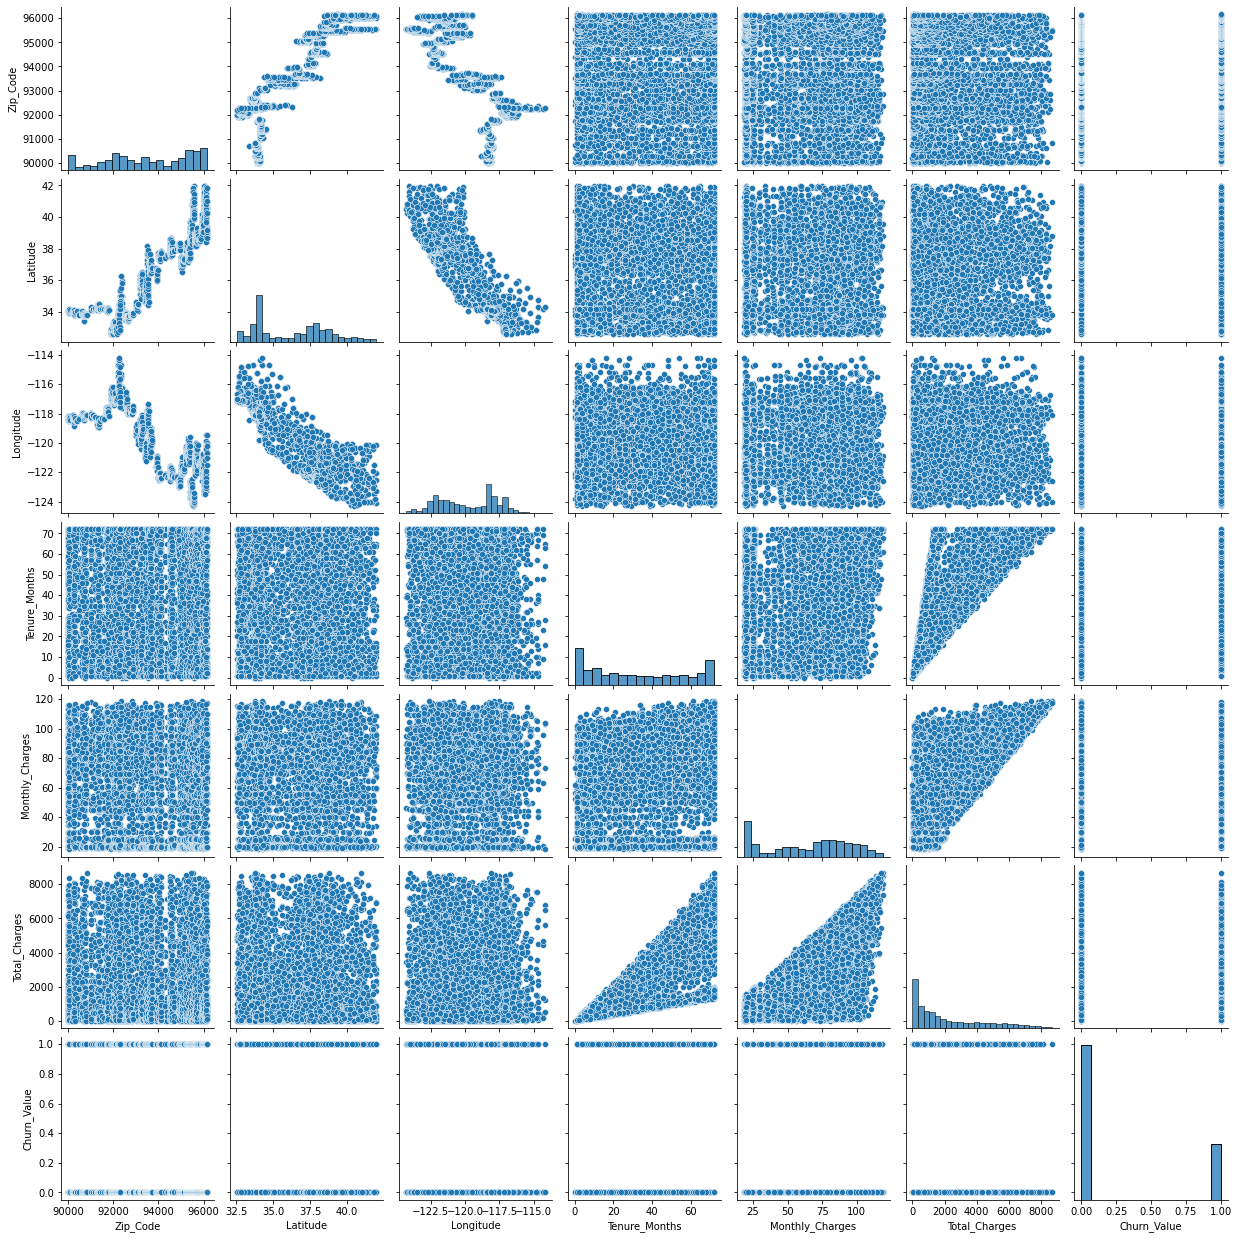

In [27]:
sns.pairplot(df)

In [28]:
## Checking for imbalanced data
df.Churn_Value.value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

## Split data its dependent and independent features


In [29]:
X = df.drop('Churn_Value', axis=1)
y = df.Churn_Value

In [30]:
X.shape, y.shape

((7043, 22), (7043,))

In [31]:
X_encoded =  pd.get_dummies(X)

In [32]:
X_encoded

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,92285,34.341737,-116.539416,72,21.15,1419.40,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
7039,92301,34.667815,-117.536183,24,84.80,1990.50,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
7040,92304,34.559882,-115.637164,72,103.20,7362.90,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
7041,92305,34.167800,-116.864330,11,29.60,346.45,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [33]:
y.unique()

array([1, 0], dtype=int64)

In [34]:
sum(y)/len(y)

0.2653698707936959

## Split data set into train and test set 
>*  using stratify this helps to maintain percentage of 0:1 which is 0.2653 in both trian and test set

In [35]:
X_train, X_test, y_train, y_test =  train_test_split(X_encoded, y, random_state=1, stratify=y)

#### now check stratify worked or not

In [36]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.2654297614539947
0.26519023282226006


##### Yes it did work

# Build XGBOOST
>* here we took objective as binary:logistic(Which is deafult for xgbclassifier) beause for classification xgboost uses logistic regression aproch to evaluate how good it is in classifying
>* Here missing=None means missing values are represented as '0' if we replace missing with something else put it here

In [37]:
clf_xgd = xgb.XGBClassifier(objective='binary:logistic',missing=None,seed=1,use_label_encoder=False)

In [38]:
clf_xgd.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set =[(X_test,y_test)])
            
# early stopping = after building 10 trees if accuracy does not impover then it will stop after 10 trees           

[0]	validation_0-aucpr:0.63554
[1]	validation_0-aucpr:0.64818
[2]	validation_0-aucpr:0.67091
[3]	validation_0-aucpr:0.67509
[4]	validation_0-aucpr:0.67925
[5]	validation_0-aucpr:0.68110
[6]	validation_0-aucpr:0.68296
[7]	validation_0-aucpr:0.68034
[8]	validation_0-aucpr:0.67723
[9]	validation_0-aucpr:0.67916
[10]	validation_0-aucpr:0.68411
[11]	validation_0-aucpr:0.68292
[12]	validation_0-aucpr:0.68210
[13]	validation_0-aucpr:0.68093
[14]	validation_0-aucpr:0.68041
[15]	validation_0-aucpr:0.68149
[16]	validation_0-aucpr:0.68017
[17]	validation_0-aucpr:0.68024
[18]	validation_0-aucpr:0.68132
[19]	validation_0-aucpr:0.68086


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

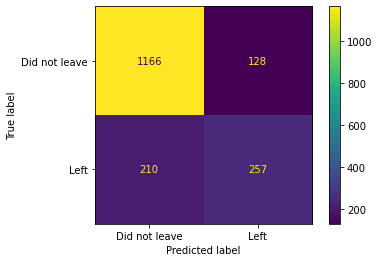

In [39]:
## Lets plot confustion matix
plot_confusion_matrix(clf_xgd,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave', 'Left']
                      );

In [91]:
clf_testpreds = clf_xgd.predict(X_test)

In [92]:
accuracy_score(y_test, clf_testpreds)

0.8080636002271436

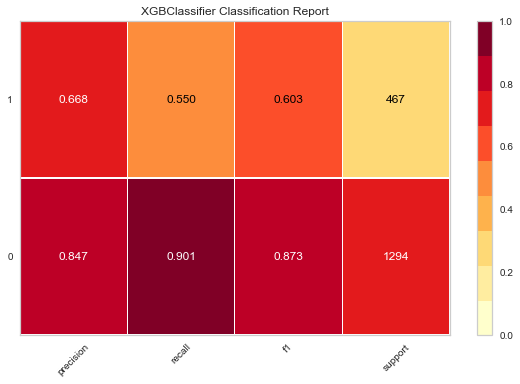

In [124]:
classes=['Did not leave', 'Left']
visulizer=classification_report(clf_xgd,X_train, y_train, X_test, y_test,ClassificationReport=classes, support=True )

## We are gitting accuracy high but precision and recall on cusomers who are leaving and so we need to deal with this imbalanced data

# Optimization of xgb using cross validation

**NOTE**- beause of imbalanced class we are not getting much accuracy so their is one parameter in xgb to deal with imbalanced data it adds penalty for incorrecly classifying minority class data 
>* scale_pos_weight - note xgb recommends sum(negative instances)/sum(+ve instances)
>* reg_lambda - regularization parameter
>* max_depth- depth of tree
>* gamma - parameter that encourages pruning( gain- gamma)

In [40]:
y.value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

In [41]:
1869/5174

0.36122922303826827

In [42]:
param_grid ={
    'max_depth': [4, 5, 6],
    'learning_rate': [0, 0.01, 0.1, 0.3],
    'gamma': [0, 1, 2],
    'reg_lambda':[0,1,2,10],
    'scale_pos_weight':[0.36,2,5]
}

In [43]:
# here we are using subsample-0.9 and colsample_bytree-0.5 to overcome overfitting
# for each tree it will use random 90% of data and only 50% of columns and its speeds things up also
# when we have imbalanced data xgb recoomeds to use auc socing metrics

# optimal_xgb = GridSearchCV(xgb.XGBClassifier(
#                                              objective='binary:logistic',missing=None,
#                                             use_label_encoder=False,
#                                             subsample=0.9,
#                                             colsample_bytree=0.5),
#                              param_grid=param_grid,
#                              scoring='roc_auc',
#                              cv=4,
#                              n_jobs=10)

In [44]:
# optimal_xgb.fit(X_train,y_train,
#                early_stopping_rounds=10,
#                eval_metric='auc',
#                eval_set=[(X_test,y_test)],
#                verbose=2)

In [45]:
# optimal_xgb.best_params_

# Now build final xgb with best params

In [52]:
ideal_xgb = xgb.XGBClassifier(seed =1,
                              objective ='binary:logistic',
                              use_label_encoder=False,
                              gamma=0,
                              learning_rate=0.1,
                              max_depth=4,
                              reg_lambda=10,
                              scale_pos_weight=2,
                              subsample=0.9,
                              colsample_bytree=0.5)


In [53]:
## Fit ideal model
ideal_xgb.fit(X_train,y_train,
              verbose=True,
              early_stopping_rounds=10,
             eval_set=[(X_test,y_test)],
             eval_metric='aucpr')


[0]	validation_0-aucpr:0.59831
[1]	validation_0-aucpr:0.62417
[2]	validation_0-aucpr:0.62735
[3]	validation_0-aucpr:0.64894
[4]	validation_0-aucpr:0.65830
[5]	validation_0-aucpr:0.66173
[6]	validation_0-aucpr:0.65980
[7]	validation_0-aucpr:0.65725
[8]	validation_0-aucpr:0.65735
[9]	validation_0-aucpr:0.66826
[10]	validation_0-aucpr:0.67075
[11]	validation_0-aucpr:0.67170
[12]	validation_0-aucpr:0.67662
[13]	validation_0-aucpr:0.67705
[14]	validation_0-aucpr:0.67525
[15]	validation_0-aucpr:0.67959
[16]	validation_0-aucpr:0.68142
[17]	validation_0-aucpr:0.68216
[18]	validation_0-aucpr:0.68431
[19]	validation_0-aucpr:0.68604
[20]	validation_0-aucpr:0.68453
[21]	validation_0-aucpr:0.68605
[22]	validation_0-aucpr:0.68710
[23]	validation_0-aucpr:0.68773
[24]	validation_0-aucpr:0.68735
[25]	validation_0-aucpr:0.68763
[26]	validation_0-aucpr:0.68806
[27]	validation_0-aucpr:0.68979
[28]	validation_0-aucpr:0.69135
[29]	validation_0-aucpr:0.69189
[30]	validation_0-aucpr:0.69422
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=2, seed=1,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### Save ideal model

In [54]:
import pickle

filename = 'D:\Machine_learning/MACHINE_LEARN/PROJECTS/Telco_churn_prediction/saved_model/ideal_xgb_classifier.sav'
pickle.dump(ideal_xgb, open(filename, 'wb'))

### Plot confusion

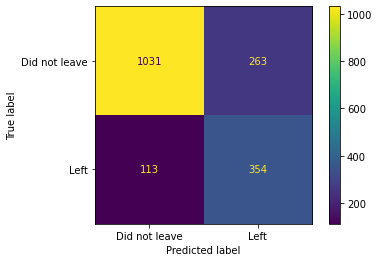

In [55]:
plot_confusion_matrix(ideal_xgb,
                     X_test,y_test,
                     display_labels=['Did not leave', 'Left'])

**Note** - Notice this model has better classified customers who were going to leave telco thats good cause we want to classify people who can leave telco

# Predictions on test set

In [66]:
test_preds = ideal_xgb.predict(X_test)

In [67]:
test_preds

array([1, 0, 0, ..., 1, 0, 1])

In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_preds)

0.7864849517319704

In [87]:
balanced_accuracy_score(y_test, test_preds)

0.7773921144865612

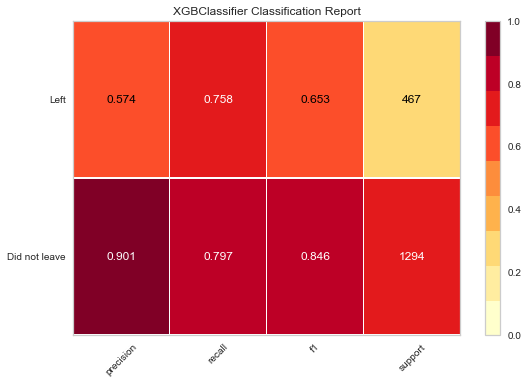

In [126]:
classification_report(ideal_xgb, X_train,y_train, X_test, y_test, classes=classes, support=True);

### **Note**-- Now our recall and precision both are better that previous model

# Visualize first tree

In [63]:
bst = ideal_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'Dependents_No': 44, 'Total_Charges': 112, 'Monthly_Charges': 90, 'Online_Backup_Yes': 5, 'Partner_No': 10, 'Latitude': 62, 'Internet_Service_No': 2, 'Online_Security_Yes': 10, 'Tech_Support_Yes': 6, 'Contract_Month-to-month': 21, 'Internet_Service_Fiber_optic': 20, 'City_San_Bernardino': 5, 'Contract_One_year': 9, 'Streaming_Movies_No': 5, 'Online_Security_No': 13, 'Longitude': 71, 'Contract_Two_year': 15, 'City_Oakland': 4, 'City_Santa_Barbara': 3, 'City_Hayward': 2, 'Tenure_Months': 91, 'Zip_Code': 95, 'Online_Backup_No': 23, 'Tech_Support_No': 12, 'Internet_Service_DSL': 19, 'Payment_Method_Credit_card_(automatic)': 12, 'Payment_Method_Electronic_check': 22, 'Partner_Yes': 13, 'Dependents_Yes': 18, 'City_Santa_Monica': 2, 'Streaming_Movies_Yes': 10, 'Phone_Service_Yes': 1, 'Senior_Citizen_No': 11, 'Senior_Citizen_Yes': 4, 'City_Palm_Desert': 1, 'Multiple_Lines_Yes': 3, 'Paperless_Billing_Yes': 4, 'Device_Protection_No': 5, 'City_Los_Angeles': 6, 'Device_Protection_Yes': 5

In [59]:
node_param = {'shape': 'box',
              'style': 'filled,rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style':'filled',
              'color':'#e48038'}

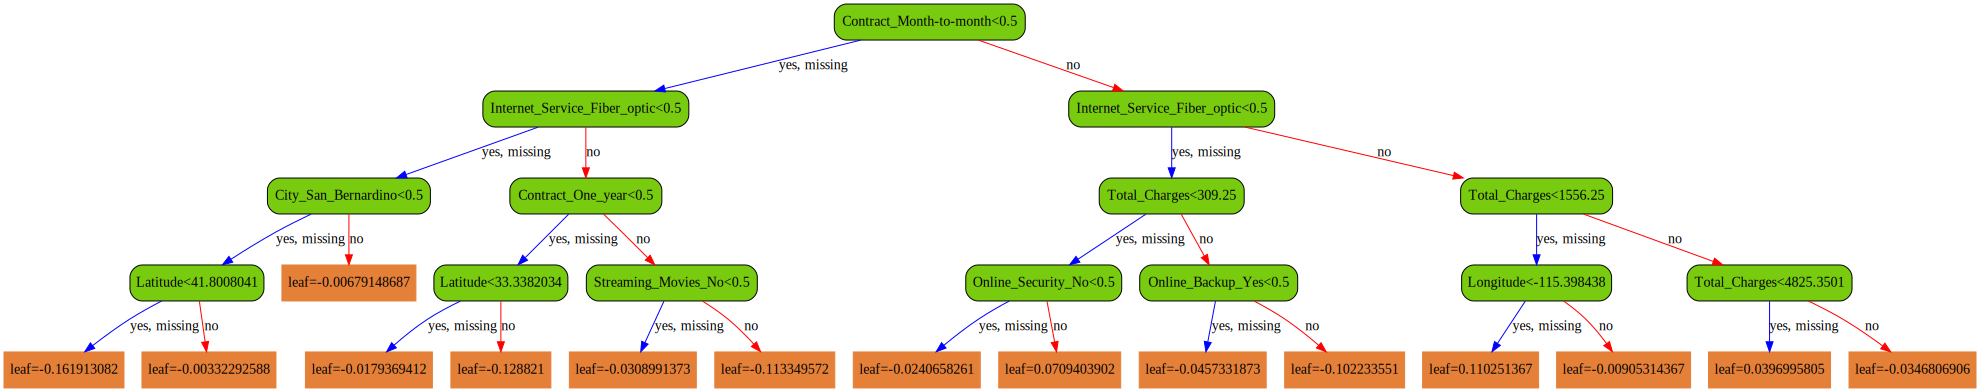

In [65]:
# this num_trees are not number of trees to plot, but specific tree we want to plot
xgb.to_graphviz(ideal_xgb, num_trees=1,
               condition_node_params=node_param,
               leaf_node_params=leaf_params)

# Feature Importance

In [72]:
ideal_xgb.feature_importances_

array([0.00593722, 0.00448349, 0.00458565, ..., 0.00513245, 0.04126148,
       0.00493604], dtype=float32)

In [84]:
def plot_feature(columns, importances, n=20 ):
    df_ =(pd.DataFrame({'features':columns,
                      'feature_importances':importances})
         .sort_values('feature_importances', ascending=False)
         .reset_index(drop=True))
    sns.barplot(x='feature_importances',
                y='features',
               data=df_[:n],
               )                  

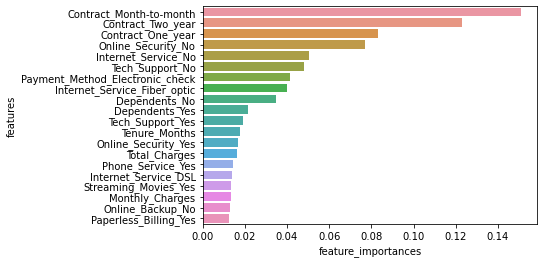

In [85]:
plot_feature(X_train.columns, ideal_xgb.feature_importances_)